<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Exercise_7_3_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Dataset with brain atlas A**: use the Oasis dataset for classification of male and female individuals based on brain scans.

``Task 3:`` Combining knowledge from task 1 and 2, plot a heatmap that shows the atlas resolution (``100-1000``) on the **x-axis** and the cluster/component number (``10`` choices) on the **y-axis**, while the color of the tiles/cubes of the heatmap shows the final out-of-sample crossvalidation estimate (``classification accuracy``). Since there are 4 different dimensionality reduction methods, there should be 4 such plots; one resolution-by-factor-number plot per clustering/decomposition method. 

Do another such 4 plots, but based on the **average training set prediction accuracy** (across the 5 training sets). You should have 8 plots overall, 2 for each reduction method.

In [ ]:
!pip install nilearn

In [ ]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib

In [ ]:
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score

In [ ]:
# We prepare the model with the required parameters 
logreg = LogisticRegression(max_iter=1e5, penalty = 'l2', C = 1, solver = 'saga')

# We prepare the inner iterating variable 
k_list = list(range(1,11))

In [ ]:
# We define the outer iterating variable
ROIs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [ ]:
# We pre-allocate the variables to store the scores
kMM_scores = []
gmm_scores = []
pca_scores = []
ica_scores = []

In [ ]:
for x in ROIs:
    brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=(x)) # We iterate through the number of ROIs
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 for females and 0 for males

    for i in k_list:
          X, y = input_variables, output_variable
          X = scaler.fit_transform(X)

          kMM = KMeans(n_clusters=i).fit(X)
          X_kMM = kMM.transform(X)
          scores1 = cross_val_score(logreg, X_kMM, y, cv=5)
          scores1 = np.multiply(scores1, 100) 
          kMM_scores.append(scores1) # We store the scores

          gmm = GaussianMixture(n_components=i).fit(X)
          gmm_X = gmm.predict_proba(X)      
          scores2 = cross_val_score(logreg, gmm_X, y, cv=5)
          scores2 = np.multiply(scores2, 100) 
          gmm_scores.append(scores2) # We store the scores

          pca = PCA(n_components=i).fit(X)
          X_pca = pca.transform(X)
          scores3 = cross_val_score(logreg, X_pca, y, cv=5)
          scores3 = np.multiply(scores3, 100) 
          pca_scores.append(scores3) # We store the scores

          ica = FastICA(n_components=i,tol=0.01).fit(X)
          X_ica = ica.transform(X)
          scores4 = cross_val_score(logreg, X_ica, y, cv=5)
          scores4 = np.multiply(scores4, 100) 
          ica_scores.append(scores4) # We store the scores

In [ ]:
n = 5
np_kMM_scores = np.array(kMM_scores)
fold_avg_kMM = np.average(np_kMM_scores.reshape(-1, n), axis=1)

np_gmm_scores = np.array(gmm_scores)
fold_avg_gmm = np.average(np_gmm_scores.reshape(-1, n), axis=1)

np_pca_scores = np.array(pca_scores)
fold_avg_pca = np.average(np_pca_scores.reshape(-1, n), axis=1)

np_ica_scores = np.array(ica_scores)
fold_avg_ica = np.average(np_ica_scores.reshape(-1, n), axis=1)

In [ ]:
fold_avg_kMM = np.reshape(fold_avg_kMM,(10,10))
fold_avg_gmm = np.reshape(fold_avg_gmm,(10,10))
fold_avg_pca = np.reshape(fold_avg_pca,(10,10))
fold_avg_ica = np.reshape(fold_avg_ica,(10,10))

In [ ]:
import seaborn as sns
import pandas as pd

df_kMM= pd.DataFrame(fold_avg_kMM)
df_kMM = df_kMM.transpose() 
df_kMM.columns =(ROIs)
df_kMM.index = (k_list)
df_kMM = df_kMM[::-1]

df_gmm= pd.DataFrame(fold_avg_gmm)
df_gmm = df_gmm.transpose() 
df_gmm.columns =(ROIs)
df_gmm.index = (k_list)
df_gmm = df_gmm[::-1]

df_pca= pd.DataFrame(fold_avg_pca)
df_pca = df_pca.transpose() 
df_pca.columns =(ROIs)
df_pca.index = (k_list)
df_pca = df_pca[::-1]

df_ica= pd.DataFrame(fold_avg_ica)
df_ica = df_ica.transpose() 
df_ica.columns =(ROIs)
df_ica.index = (k_list)
df_ica = df_ica[::-1]

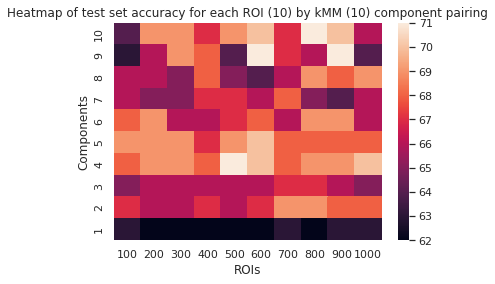

In [ ]:
sns.set()
ax = sns.heatmap(df_kMM)
ax.set(title='Heatmap of test set accuracy for each ROI (10) by kMM (10) component pairing', xlabel='ROIs', ylabel='Components')
plt.show()


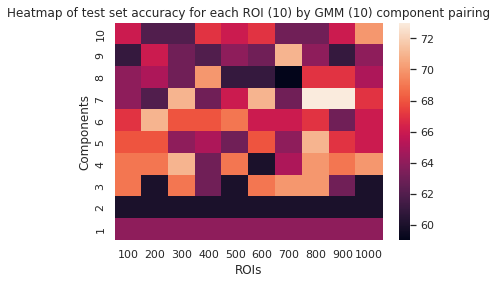

In [ ]:
sns.set()
ax = sns.heatmap(df_gmm)
ax.set(title='Heatmap of test set accuracy for each ROI (10) by GMM (10) component pairing', xlabel='ROIs', ylabel='Components')
plt.show()

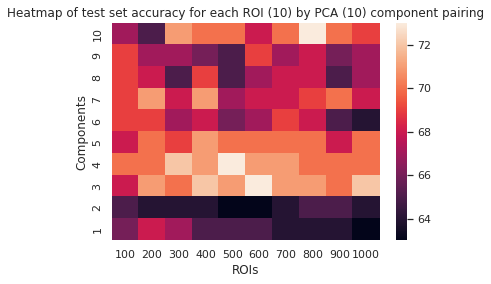

In [ ]:
sns.set()
ax = sns.heatmap(df_pca)
ax.set(title='Heatmap of test set accuracy for each ROI (10) by PCA (10) component pairing', xlabel='ROIs', ylabel='Components')
plt.show()

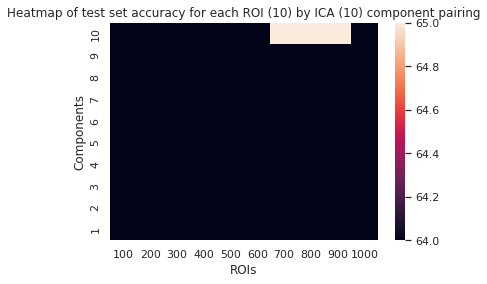

In [ ]:
sns.set()
ax = sns.heatmap(df_ica)
ax.set(title='Heatmap of test set accuracy for each ROI (10) by ICA (10) component pairing', xlabel='ROIs', ylabel='Components')
plt.show()